In [1]:
%pip install transformers torch pandas numpy kagglehub hf_transfer scikit-learn matplotlib rich

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 56.9 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 7.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 56.8 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 32.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 57.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 49.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 46.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.0/802.0 kB 9.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 86.5 MB/s  0:00:006m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24/24 [transformers] [tr

In [2]:
import torch
import transformers
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)

Torch: 2.8.0+cu128
Transformers: 4.57.1


In [3]:
import kagglehub

path = kagglehub.dataset_download("andrewmvd/cyberbullying-classification")

print("Path to dataset files:", path)

100%|██████████| 2.82M/2.82M [00:00<00:00, 4.17MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/cyberbullying-classification/versions/1


In [4]:
import torch, gc
torch.cuda.empty_cache()
gc.collect()

110

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import torch, gc
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import logging
import matplotlib.pyplot as plt
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn, TextColumn
from transformers import get_linear_schedule_with_warmup
from torch.amp import autocast, GradScaler
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torch.optim.lr_scheduler")
logging.set_verbosity_error()

console = Console()

torch.cuda.empty_cache()
gc.collect()
print("Cleared GPU cache ✅")

os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


path = '/root/.cache/kagglehub/datasets/andrewmvd/cyberbullying-classification/versions/1/cyberbullying_tweets.csv'

df = pd.read_csv(path, sep=',')


label_map = {
    'not_cyberbullying' : 0,
    'gender' : 1,
    'religion' : 2,
    'other_cyberbullying' : 3,
    'age' : 4,
    'ethnicity' : 5
}

df["label"] = df["cyberbullying_type"].map(label_map)
num_labels=df['label'].nunique()



def preprocess(tweet):
    return tokenizer(tweet, truncation=True, padding='max_length', max_length=128)


tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoded_tweets = df['tweet_text'].apply(preprocess)

df["input_ids"] = encoded_tweets.apply(lambda x: x["input_ids"])
df["attention_mask"] = encoded_tweets.apply(lambda x: x["attention_mask"])

# Convert to tensors
inputs = torch.tensor(df["input_ids"].tolist())
masks = torch.tensor(df["attention_mask"].tolist())
labels = torch.tensor(df["label"].tolist())

dataset = TensorDataset(inputs, masks, labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

Cleared GPU cache ✅


In [7]:
# Train model
def train_model(num_epochs, scheduler):
    scaler = GradScaler()
    for epoch in range(num_epochs):
        model.train()
        total_loss=0
        console.rule(f"[bold green]Epoch {epoch+1}/{num_epochs}", align='center')
        with Progress(
            TextColumn("[bold dodger_blue1]{task.description}"),
            BarColumn(),
            TextColumn("[bold dodger_blue1]{task.percentage:>3.1f}%[/bold dodger_blue1]"),
            "•",
            TimeElapsedColumn(),
            "•",
            TimeRemainingColumn(),
            console=console,
            transient=True,
        ) as progress:
            task = progress.add_task("Training", total=len(train_loader))
            
            for batch in train_loader:
                batch = [x.to(device) for x in batch]
                optimizer.zero_grad()
                with autocast(device_type="cuda", dtype=torch.bfloat16): 
                    outputs = model(input_ids=batch[0].to(device), attention_mask=batch[1].to(device), labels=batch[2].to(device))
                    loss = outputs.loss
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                
                total_loss += loss.item()

                progress.advance(task)
                progress.update(task, description=f"Training (loss={loss.item():.4f})")
        avg_loss = total_loss / len(train_loader)
        console.print(f'[orchid1]Epoch {epoch+1} completed | Average loss: [bold bright_yellow]{avg_loss:.4f}[/bold bright_yellow]\n')
    return model



def eval_model(model, confidence_threshold=0.55):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = [x.to(device) for x in batch]
            outputs = model(input_ids=batch[0], attention_mask=batch[1])
            
            # Softmax probabilities
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            confs, preds = torch.max(probs, dim=1)

            # Apply confidence filtering
            for c, p, lbl in zip(confs.cpu(), preds.cpu(), batch[2].cpu()):
                if c >= confidence_threshold:
                    all_preds.append(p.item())
                else:
                    all_preds.append(-1)   # -1 = uncertain / skipped
                all_labels.append(lbl.item())
                all_probs.append(c.item())

    # Filter out uncertain predictions
    valid_indices = [i for i, p in enumerate(all_preds) if p != -1]
    filtered_preds = [all_preds[i] for i in valid_indices]
    filtered_labels = [all_labels[i] for i in valid_indices]

    print(f"\n⚙️ Confidence threshold: {confidence_threshold}")
    print(f"Filtered out {len(all_preds) - len(filtered_preds)} low-confidence predictions.")
    print(f"Effective evaluation size: {len(filtered_preds)} samples\n")

    # Confusion Matrix
    cm = confusion_matrix(filtered_labels, filtered_preds, labels=list(range(num_labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.show()

    # Metrics
    acc = accuracy_score(filtered_labels, filtered_preds)
    f1 = f1_score(filtered_labels, filtered_preds, average="macro")

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print("\nDetailed report:\n", classification_report(filtered_labels, filtered_preds))

    return acc, f1

In [ ]:
if __name__ == "__main__":
    epochs = 10
    best_lr = 3e-5
    num_training_steps = len(train_loader) * epochs

    print("Running on:", torch.cuda.get_device_name(0))

    model = AutoModelForSequenceClassification.from_pretrained(
        "google-bert/bert-large-uncased", num_labels=num_labels)
    
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False
    for layer in model.bert.encoder.layer[:8]:
        for param in layer.parameters():
            param.requires_grad = False

    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=best_lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * num_training_steps),
        num_training_steps=num_training_steps
    )

    trained_model = train_model(epochs, scheduler)
    eval_model(trained_model)

    # Save only the last run (optional)
    trained_model.save_pretrained('bert_cyberbullying_model')
    tokenizer.save_pretrained('bert_cyberbullying_model')

ERROR! Session/line number was not unique in database. History logging moved to new session 2


─────────────────────────────────────────────────── Epoch 1/10 ────────────────────────────────────────────────────

Output()

Epoch 1 completed | Average loss: 0.8377

─────────────────────────────────────────────────── Epoch 2/10 ────────────────────────────────────────────────────

Output()

Epoch 2 completed | Average loss: 0.3464

─────────────────────────────────────────────────── Epoch 3/10 ────────────────────────────────────────────────────

Output()

Epoch 3 completed | Average loss: 0.2637

─────────────────────────────────────────────────── Epoch 4/10 ────────────────────────────────────────────────────

Output()

Epoch 4 completed | Average loss: 0.2007

─────────────────────────────────────────────────── Epoch 5/10 ────────────────────────────────────────────────────

Output()

Epoch 5 completed | Average loss: 0.1508

─────────────────────────────────────────────────── Epoch 6/10 ────────────────────────────────────────────────────

Output()

Epoch 6 completed | Average loss: 0.1172

─────────────────────────────────────────────────── Epoch 7/10 ────────────────────────────────────────────────────

Output()

Epoch 7 completed | Average loss: 0.0996

─────────────────────────────────────────────────── Epoch 8/10 ────────────────────────────────────────────────────

Output()

Epoch 8 completed | Average loss: 0.0830

─────────────────────────────────────────────────── Epoch 9/10 ────────────────────────────────────────────────────

Output()

Epoch 9 completed | Average loss: 0.0728

─────────────────────────────────────────────────── Epoch 10/10 ───────────────────────────────────────────────────

Output()

Epoch 10 completed | Average loss: 0.0645


Testing confidence threshold = 0.65

⚙️ Confidence threshold: 0.65
Filtered out 328 low-confidence predictions.
Effective evaluation size: 9211 samples



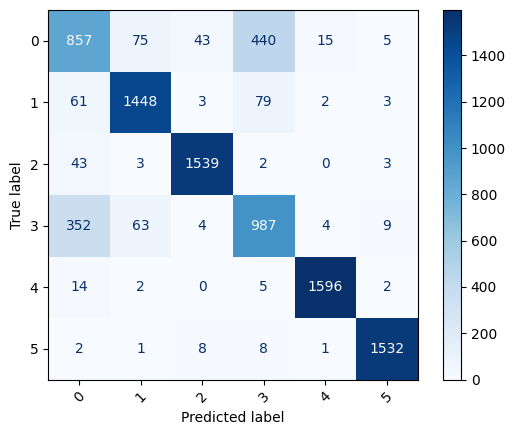

Accuracy: 0.8641
F1 Score (macro): 0.8564

Detailed report:
               precision    recall  f1-score   support

           0       0.64      0.60      0.62      1435
           1       0.91      0.91      0.91      1596
           2       0.96      0.97      0.97      1590
           3       0.65      0.70      0.67      1419
           4       0.99      0.99      0.99      1619
           5       0.99      0.99      0.99      1552

    accuracy                           0.86      9211
   macro avg       0.86      0.86      0.86      9211
weighted avg       0.86      0.86      0.86      9211


Testing confidence threshold = 0.7

⚙️ Confidence threshold: 0.7
Filtered out 446 low-confidence predictions.
Effective evaluation size: 9093 samples



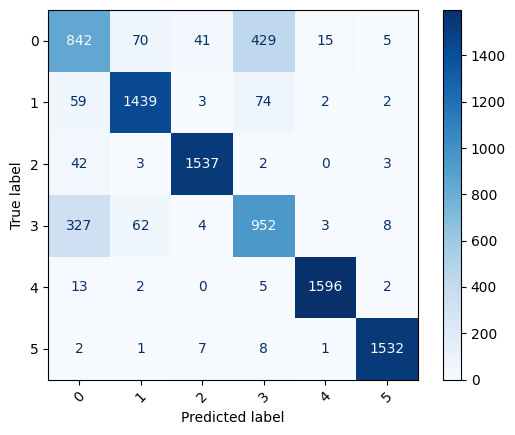

Accuracy: 0.8686
F1 Score (macro): 0.8589

Detailed report:
               precision    recall  f1-score   support

           0       0.66      0.60      0.63      1402
           1       0.91      0.91      0.91      1579
           2       0.97      0.97      0.97      1587
           3       0.65      0.70      0.67      1356
           4       0.99      0.99      0.99      1618
           5       0.99      0.99      0.99      1551

    accuracy                           0.87      9093
   macro avg       0.86      0.86      0.86      9093
weighted avg       0.87      0.87      0.87      9093


Testing confidence threshold = 0.75

⚙️ Confidence threshold: 0.75
Filtered out 586 low-confidence predictions.
Effective evaluation size: 8953 samples



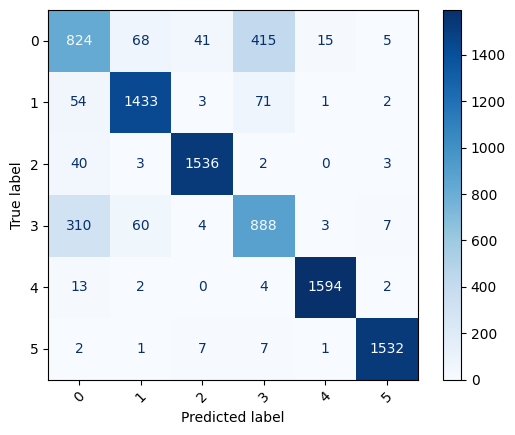

Accuracy: 0.8720
F1 Score (macro): 0.8596

Detailed report:
               precision    recall  f1-score   support

           0       0.66      0.60      0.63      1368
           1       0.91      0.92      0.92      1564
           2       0.97      0.97      0.97      1584
           3       0.64      0.70      0.67      1272
           4       0.99      0.99      0.99      1615
           5       0.99      0.99      0.99      1550

    accuracy                           0.87      8953
   macro avg       0.86      0.86      0.86      8953
weighted avg       0.87      0.87      0.87      8953


Testing confidence threshold = 0.8

⚙️ Confidence threshold: 0.8
Filtered out 732 low-confidence predictions.
Effective evaluation size: 8807 samples



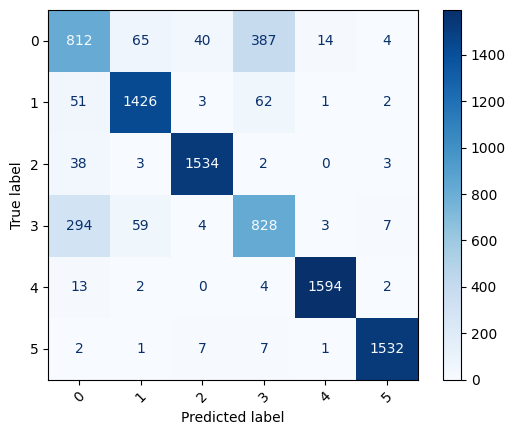

Accuracy: 0.8773
F1 Score (macro): 0.8620

Detailed report:
               precision    recall  f1-score   support

           0       0.67      0.61      0.64      1322
           1       0.92      0.92      0.92      1545
           2       0.97      0.97      0.97      1580
           3       0.64      0.69      0.67      1195
           4       0.99      0.99      0.99      1615
           5       0.99      0.99      0.99      1550

    accuracy                           0.88      8807
   macro avg       0.86      0.86      0.86      8807
weighted avg       0.88      0.88      0.88      8807


Testing confidence threshold = 0.85

⚙️ Confidence threshold: 0.85
Filtered out 941 low-confidence predictions.
Effective evaluation size: 8598 samples



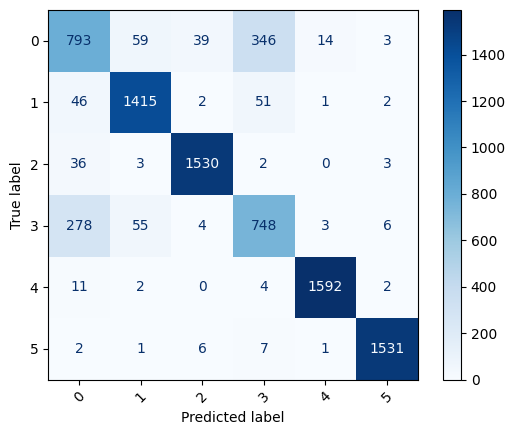

Accuracy: 0.8850
F1 Score (macro): 0.8657

Detailed report:
               precision    recall  f1-score   support

           0       0.68      0.63      0.66      1254
           1       0.92      0.93      0.93      1517
           2       0.97      0.97      0.97      1574
           3       0.65      0.68      0.66      1094
           4       0.99      0.99      0.99      1611
           5       0.99      0.99      0.99      1548

    accuracy                           0.88      8598
   macro avg       0.87      0.87      0.87      8598
weighted avg       0.88      0.88      0.88      8598


Best Accuracy: 0.8850 at threshold 0.85
Best F1 Score: 0.8657 at threshold 0.85


In [13]:
epochs = 10
best_lr = 3e-5
num_training_steps = len(train_loader) * epochs

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-large-uncased", num_labels=num_labels).to(device)

for param in model.bert.embeddings.parameters():
    param.requires_grad = False
for layer in model.bert.encoder.layer[:8]:
    for param in layer.parameters():
        param.requires_grad = False

optimizer = AdamW(model.parameters(), lr=best_lr)
scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * num_training_steps),
            num_training_steps=num_training_steps
        )

trained_model = train_model(epochs, scheduler)

acc, f1 = eval_model(trained_model, confidence_threshold=t)

print(f"\nAccuracy: {acc}")
print(f"\nF1 Score: {f1}")

In [15]:
trained_model.save_pretrained('bert_cyberbullying_model')
tokenizer.save_pretrained('bert_cyberbullying_model')

import os
os.listdir('bert_cyberbullying_model')

['tokenizer.json',
 'vocab.txt',
 'special_tokens_map.json',
 'tokenizer_config.json',
 'model.safetensors',
 'config.json']